In [1]:
!pip3 uninstall torchtext -y
!pip3 uninstall torchvision -y
!pip3 uninstall torch -y

Found existing installation: torch 1.9.0
Uninstalling torch-1.9.0:
  Successfully uninstalled torch-1.9.0


In [2]:
!pip3 install torch==1.9.0

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 831.4 MB 22.9 MB/s eta 0:00:01     |██████▊                         | 174.1 MB 23.8 MB/s eta 0:00:28     |██████████████████              | 470.0 MB 22.0 MB/s eta 0:00:17     |██████████████████████          | 572.2 MB 23.2 MB/s eta 0:00:12     |███████████████████████████████▋| 820.8 MB 22.9 MB/s eta 0:00:01


In [3]:
import torch                                                                                                                                            
pytorch_version=f'torch-{torch.__version__}.html'                                                                                                 
!pip3 install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip3 install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip3 install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip3 install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip3 install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 8.0 MB 5.3 MB/s eta 0:00:01
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 2.9 MB 7.3 MB/s eta 0:00:01
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 1.4 MB 7.1 MB/s eta 0:00:01
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 677 kB 7.0 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import torch

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [5]:
from torch_geometric.datasets import CitationFull

dataset =  CitationFull(root='.', name='DBLP' )  

#Divisor de trianamento, validação e teste

div_train = int( len(dataset[0].y)*  6/10 ) 
div_val = int( len(dataset[0].y)* 8/10 )
div_test = len( dataset[0].y )

#Número de classes

num_classes = dataset.num_classes

In [6]:
num_classes

4

In [7]:
data = dataset[0].to(device)

In [8]:
len(dataset)

1

In [9]:
from torch.nn import Module 
from torch.nn.functional import relu, log_softmax
from torch_geometric.nn import GCNConv

EMBEDDING_SIZE = 16

class GCN(Module):
    
    def __init__(self, input_channel, output_channel):
        super().__init__()
        
        #Definir as camadas
        
        self.conv1 = GCNConv(input_channel, EMBEDDING_SIZE)
        self.conv2 = GCNConv(EMBEDDING_SIZE, output_channel)
        
    
    def forward(self, x, edge_index):
        #Lógica de computação da rede
    
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        
        return log_softmax(x, dim=1)

In [10]:
input_channel = dataset.num_node_features
output_channel = dataset.num_classes

model = GCN(input_channel, output_channel).to(device)

In [11]:
import torch

loss_function = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) 

In [12]:
def train():
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index) 
    
    train_x = out[ :div_train ]
    train_y = data.y[ :div_train ]
    
    loss = loss_function(train_x, train_y) 
    loss.backward()  
    optimizer.step() 
        
    return loss

In [13]:
def aval_train():
    pred = model(data.x, data.edge_index).argmax(dim=1) # Realiza predições
    correct = (pred[ div_train: div_val ] == data.y[ div_train:div_val ]).sum() # Soma os acertos totais
    acc = int(correct) / len(data.y[ div_train:div_val ]) # Calcula a acurácia acertos / total
    return acc

In [23]:
import numpy as np

#Define o número de epochs
num_epochs = 600 

#Listas de acurácia e de loss
accuracies = []
losses = []

epochs = np.arange(1, num_epochs+1)

for epoch in epochs:
    loss = train() #Realiza o treinamento
    accuracy = aval_train() #Calcula a acurácia
    losses.append(float(loss)) #Anexa o loss atual a lista de losses
    accuracies.append(accuracy) # Anexa a acurácia atual na lista de acuracias
    if epoch%50 == 0: print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acurácia: {accuracy}') #Imprima o status a cada 50 epochs

Epoch: 050, Loss: 0.2760, Acurácia: 0.8182331357606548
Epoch: 100, Loss: 0.2696, Acurácia: 0.8168219023426475
Epoch: 150, Loss: 0.2646, Acurácia: 0.812305955405024
Epoch: 200, Loss: 0.2608, Acurácia: 0.8086367485182049
Epoch: 250, Loss: 0.2577, Acurácia: 0.8120237087214225
Epoch: 300, Loss: 0.2555, Acurácia: 0.8100479819362123
Epoch: 350, Loss: 0.2538, Acurácia: 0.8131526954558284
Epoch: 400, Loss: 0.2522, Acurácia: 0.8128704487722269
Epoch: 450, Loss: 0.2509, Acurácia: 0.8125882020886255
Epoch: 500, Loss: 0.2499, Acurácia: 0.8151284222410387
Epoch: 550, Loss: 0.2490, Acurácia: 0.8151284222410387
Epoch: 600, Loss: 0.2484, Acurácia: 0.8134349421394299


In [24]:
def aval_final():
    pred = model(data.x, data.edge_index).argmax(dim=1) # Realiza predições
    correct = (pred[ div_val: div_test ] == data.y[ div_val: div_test ]).sum() # Soma os acertos totais
    acc = int(correct) / len(data.y[ div_val:div_test ]) # Calcula a acurácia acertos / total
    print('Total de acertos: ', int(correct))
    print('Total de dados comparados: ', len(data.y[ div_val:div_test ])) 
    print(f'Acurácia final: {acc:.2f}')
    return acc

In [25]:
acc = aval_final()

Total de acertos:  2338
Total de dados comparados:  3544
Acurácia final: 0.66


[Text(0.5, 0, 'EPOCH')]

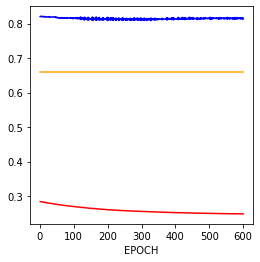

In [26]:
import matplotlib.pyplot as plt 
#%matplotlib notebook

l = len(epochs)*[acc]

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(epochs, losses, color='red')
ax.plot(epochs, accuracies, color='blue')
ax.plot(epochs, l, color='orange')
ax.set(xlabel='EPOCH')

In [27]:
fig.savefig('resultado2.jpeg', dpi=300, format='jpg')